In [398]:
import glob
import pandas as pd
from array import ArrayType
import numpy as np

# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
# saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"

In [399]:
import paradigmSetting
day = "08" # Which month and days result you want to visualize in table
month = 12
# paradigm = paradigmSetting.upDownRightLeftVis()
# paradigm = paradigmSetting.upDownInner()
# paradigm = paradigmSetting.upDownVis()

# paradigm = paradigmSetting.rightLeftInner()

# paradigm = paradigmSetting.rightLeftVis()


# paradigm = paradigmSetting.upDownRightLeftInner()
#paradigm = paradigmSetting.upDownVis()
nrOfLabels = 4


cmbSize = 3
repetitionValue = 26
featureSelect = "myOwnTestAvg" # 
paradigm = paradigmSetting.sadAngryHappyDisgustedJulia()
# featureSelect = "myOwnTestAvgRef" #  

# featureSelect = "nietoTest" # 
# paradigm = paradigmSetting.upDownRightLeftInner()
# paradigm = paradigmSetting.upDownRightLeftInner()
# paradigm = paradigmSetting.rightLeftInner()

# featureSelect = "OnlySepOnlyCurr01thTESTHoldOut70"
paraName = paradigm[0]
labels = np.arange(nrOfLabels) 
saveTop = True
saveHoldTop = True
saveSepTop = True
saveAvgTop = False
import matplotlib as mpl
mpl.rcParams["figure.dpi"]  = 80


In [400]:
repetitionName = f"{paraName}{cmbSize}c{featureSelect}" #"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")
if saveTop:
    saveTopName = f"top{cmbSize}{paraName}.npy"
else:
    saveTopName = None
if saveAvgTop:
    saveTopAvgName = f"topAvg{cmbSize}{paraName}.npy"
else:
    saveTopAvgName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)

63
7.0


In [401]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__, reverse=True)

def getRes(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels, bestSeparate=False): 
    labelAdded = 0
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1] + 1
    # print(labels)
    # print(combResLabel)
    # print(label)
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(sres[0])
                # if onlySignificant == True:
                #     if res[1] < minAcc:
                #         continue
                res[1] = round(sres[label+1 - labelAdded],2)
                # print(sres)
                
                combRes = round(sres[combResLabel+1 - labelAdded],2)
                if bestSeparate:
                    combRes = res[1]
                # print(res[1])
                # print(combRes)
                # print(combResLabel)
                # print(combResLabel+1)
                # print(combResLabel+2)
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                
                if combRes > topCombResPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topCombResTen) < 10 or topCombResTen[-1][0] < combRes:
                    
                    if len(topTen) == 10:
                        # topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        # topTen.reverse()
                        topCombResTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort(reverse=True, key= lambda i: i[0])
                    # print("preSort")
                    # print(topCombResTen)
                    topCombResTen.sort(reverse=True, key= lambda i: i[0])
                    # print("postSort")
                    # print(topCombResTen)
                    
                    
                # if len(topCombResThreeThisSubject) > 1:
                #     # print(topCombResThreeThisSubject[0][0])
                #     # print("heyNoni")
                #     # print(topCombResThreeThisSubject[1][0])
                 
                if len(topCombResThreeThisSubject) < 2 or topCombResThreeThisSubject[-1][0] < combRes:
                    # print(topCombResThreeThisSubject)
                    # print(sres)
                    if len(topThreeThisSubject) == 2:
                        # topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        # print(f"PrePop{topCombResThreeThisSubject}")
                        #topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                        # print(f"PostPop{topCombResThreeThisSubject}")
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    # print(f"CombResPreSort: {topCombResThreeThisSubject}")
                    # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    # print(f"CombResPostSort: {topCombResThreeThisSubject}")
                    if len(topCombResThreeThisSubject) > 1:
                        # print(f"SepResPreSort: {topThreeThisSubject}")
                        
                        indices = argsort(topCombResThreeThisSubject)
                        # print(indices)
                        tempCombtopThreeThisSubject= [] 
                        tempCombtopThreeThisSubject.append(topCombResThreeThisSubject[indices[0]])
                        tempCombtopThreeThisSubject.append(topCombResThreeThisSubject[indices[1]])
                        topCombResThreeThisSubject = tempCombtopThreeThisSubject
                        
                        temptopThreeThisSubject= [] 
                        temptopThreeThisSubject.append(topThreeThisSubject[indices[0]])
                        temptopThreeThisSubject.append(topThreeThisSubject[indices[1]])
                        topThreeThisSubject = temptopThreeThisSubject
                        # print(f"SepResPostSort: {topThreeThisSubject}")
                    # sortIndices = topThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    
                    # topThreeThisSubject = topThreeThisSubject[sortIndices]
                    
                    # print(f"PreSort{topCombResThreeThisSubject}")
                    # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    
                    # print(f"PostSort{topCombResThreeThisSubject}")
                    
                    
        if len(topThreeThisSubject)>0:
            # print(f"PreLastSort{topThreeThisSubject}")
            # topThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
            # print(f"PostLastSort{topThreeThisSubject}")
            topThreeAllSubjects.append(topThreeThisSubject)

        if len(topCombResThreeThisSubject)>0:
            # print(f"PreLastSort{topCombResThreeThisSubject}")
            # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
            # print(f"PostLastSort{topCombResThreeThisSubject}")
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    # comboAverage = comboAverage / nrOfSubjects
    # pd.set_option("display.max_columns", None)

    # # For loop through zip of headers and columns,
    # # If column has all values == None, Remove column and header.
    # subjectResultArray = np.array(subjectResultArray)
    # emptyCols = []
    # atleastOneEmpty = False
    # for hcol, in zip(headers):
    #     if all(subjectResultArray[:,hcol] == None):
    #         atleastOneEmpty = True
    #         emptyCols.append(hcol)
    # if atleastOneEmpty: 
    #     subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    #     headers = np.delete(headers, np.array(emptyCols),0)
    #     comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    #     comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    #     nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


In [402]:
def plotTop(topPerFeature, featCombos, label, saveTopAvgName):
    import matplotlib.pyplot as plt
    meanTop = np.mean(topPerFeature[1:], axis=0)
    indices = np.argsort(meanTop, axis=0)[::-1]
    #print(f"JULIAAA{featCombos[]}")

    # print(indices.shape)
    featCombos = np.array(featCombos)
    worstCombos = None
    if len(featCombos) < 30:
        plt.figure(figsize=[15,5])
        plt.boxplot(topPerFeature[1:, indices][:,:30])
        plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
        plt.title(f"Avg acc ")
        # print("")
    else: 
        rndmChance = (1/nrOfLabels) * 1.25
        print(rndmChance)
        print("julia")
        print(topPerFeature.shape)
        maxPerFeat = np.max(topPerFeature, axis=0)
        print(maxPerFeat.shape)

        lowerThanRndmChance = np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]) + 1
        #lowerThanRndmChance = np.count_nonzero(topPerFeature)
        print(np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]))
        print(np.count_nonzero(maxPerFeat))
        # plt.figure(figsize=[30,10])
        # plt.boxplot(topPerFeature[1:, indices][:,:])
        # plt.xticks(np.arange(len(featCombos))+1,featCombos[indices][:],rotation=90)
        # print(featCombos[indices][-30:])
        badCombos = dict()
        worstCombos = dict()
        for combo in featCombos[indices][-lowerThanRndmChance:]:
            combo = combo.split("peak")[0]
            combo = combo.split("const")[0]
            combo = combo.split("late")[0]
            combo = combo.split("myOwnTestFirst")[0]
            combo = combo.split("myOwnTestSecond")[0]
            combo = combo.split("myOwnTestThird")[0]
            if badCombos.get(combo) is None:
                badCombos[combo] = 1
            else:
                badCombos[combo] += 1
                
        for bcombos in badCombos:
            if badCombos[bcombos] > 2:
                worstCombos[bcombos] = 1
                # print("BadCombo")
                # print(bcombos)
                # print(badCombos[bcombos])
        # plt.title(f"Label {label+1}")
        print("")
        plt.figure(figsize=[15,5])
        plt.boxplot(topPerFeature[1:, indices][:,:20])
        plt.xticks(np.arange(20)+1,featCombos[indices][:20],rotation=90)
        plt.title(f"Avg acc ")
        
        # print("")
        

    arrayOfTopFeatureNames2 = featCombos[indices[0:2]]
    print(arrayOfTopFeatureNames2)
    arrayOfTopFeatureNames2 = np.array(arrayOfTopFeatureNames2, dtype=object)
    newArrayOfTopFeatureNames2 = []
    for topNames in arrayOfTopFeatureNames2:
        splitArray = []
        if "_&_" in topNames:
            splitArray = np.array(topNames.split("_&_"), dtype=object)
        else: 
            splitArray = [topNames]

        skip = False  
        if len(splitArray) < cmbSize:
            continue
        newArrayOfTopFeatureNames2.append(splitArray)
        
    print(newArrayOfTopFeatureNames2)
    newArrayOfTopFeatureNames2 = np.array(newArrayOfTopFeatureNames2, dtype=object) 
    if saveTopAvgName is not None:
        np.save(f"topFeatures/{saveTopAvgName}", newArrayOfTopFeatureNames2)
        print("TopFeatureNameArraySaved")
        print(newArrayOfTopFeatureNames2)
    return worstCombos
        

In [403]:
# All results table
nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    for featCombo in subinfo[1]:
        if featCombo not in featCombos:
            featCombos.append(featCombo)

allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1

timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])
hcombinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])

combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)
    
    currSubj = subject[1]

    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                aName = aResults2[0]
                ares = aResults2[1][0]
                sepRes = aResults2[1]
                # print(sepRes)
                # print(ares)
                akernel = aResults2[2]
                aC = aResults2[3]
                # print(sepRes)
                # print(ares)
                
                if ares > 0.99:
                    ares = 0.99
                ares = round(ares,2)
                hsepRes = aResults2[4]
                # print(hsepRes)
                for i, r in enumerate(hsepRes):
                    if r > 0.99:
                        hsepRes[i] = 0.99
                        # print("AAAAAAA")
                    hsepRes[i] = round(hsepRes[i],2)
                for i, r in enumerate(sepRes):
                    if r > 0.99:
                        sepRes[i] = 0.99
                    sepRes[i] = round(sepRes[i],2)
                        # print("AAAAAAA")
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                    for ind, seperRes in enumerate(sepRes[1:]):
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += seperRes
                    combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += sepRes[0]
                    
                    for ind, hseperRes in enumerate(hsepRes[1:]):
                        hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += hseperRes
                    hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += hsepRes[0]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    combinationResultSep[subNr,:, 1:] = combinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]
    hcombinationResultSep[subNr,:, 1:] = hcombinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]

    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            res[1] = round(res[1],2)
            cmbNr = int(res[0])
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort(key= lambda i: i[0])
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort(key= lambda i: i[0])
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
# for hcol, in zip(headers):
#     if all(subjectResultArray[:,hcol] == None):
#         atleastOneEmpty = True
#         emptyCols.append(hcol)
# if atleastOneEmpty: 
#     subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
#     headers = np.delete(headers, np.array(emptyCols),0)
#     comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
#     comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
#     nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)

# print(combinationResultSep)




,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,None,None,None,None,None,None,None,None,None,None,None
1,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
2,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
3,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
4,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
5,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
6,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
7,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
8,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4
9,0.31,0.4,0.36,0.3,0.38,0.37,0.47,0.4,0.43,0.42,0.36,0.4


(36, 7)
Sad
Angry
Happy
Disgusted


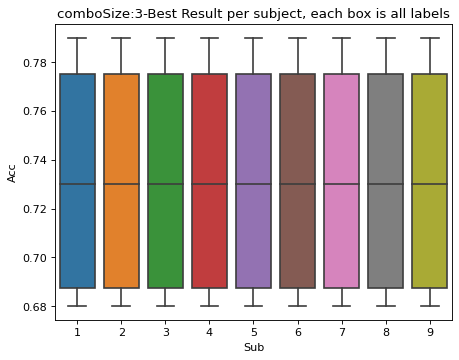

ow


,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.69,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,linear,2.5,Sad,jjjjsahd
9,0.68,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,linear,2.5,Angry,jjjjsahd
18,0.77,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,linear,2.5,Happy,jjjjsahd
27,0.79,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,linear,2.5,Disgusted,jjjjsahd


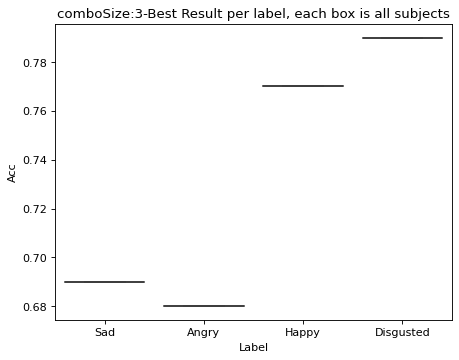

In [404]:
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels)
    # table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    # print(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
   
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
#print(labels)
labelAdded = 0
for label in labels:
    topDF.loc[topDF['Label'] == f"{label + 1 - labelAdded}", 'Label'] = paradigm[1][1][label-labelAdded][0]
    print(paradigm[1][1][label-labelAdded][0])
    # print(topDF.loc[topDF['Label'] == f"{label+1 - labelAdded}", 'Label'])

import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"topFeaturesResults/topPerSubj-para-{paraName}-cmb-{cmbSize}")
if saveAvgTop:
    topDF.to_csv(f"topFeaturesResultsAvg/topPerSubj-para-{paraName}-cmb-{cmbSize}")
plt.figure()
sns.boxplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(topDF, y = "Acc", x="Label") # , 
if "my" in featureSelect:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst
   

(36, 7)
Sad
Angry
Happy
Disgusted


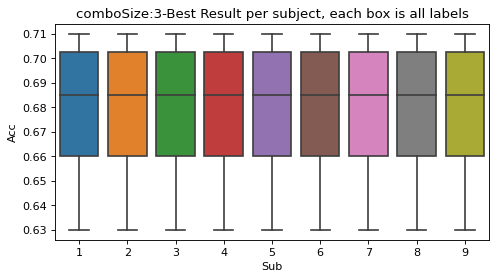

ow


,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.67,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,sigmoid,2.5,Sad,jjjjsahd
9,0.63,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,sigmoid,2.5,Angry,jjjjsahd
18,0.71,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,sigmoid,2.5,Happy,jjjjsahd
27,0.70,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,sigmoid,2.5,Disgusted,jjjjsahd


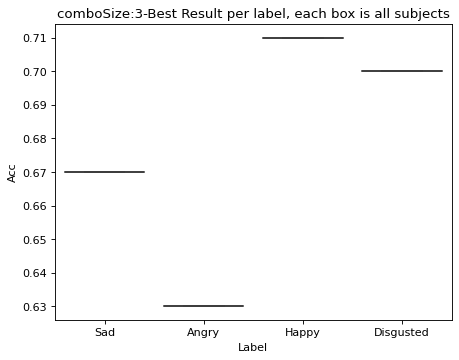

In [405]:
# Using HoldOutSet
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=hcombinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
   
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
#print(labels)
for label in labels:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])

import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveHoldTop:
    topDF.to_csv(f"topFeaturesResultsHold/topPerSubj-para-{paraName}-cmb-{cmbSize}")

plt.figure(figsize=[7,3.5])
sns.boxplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(topDF, y = "Acc", x="Label") # , 
if "my" in featureSelect:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst
   

['normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10'
 'stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10']
[array(['normData_GR_CV_BCmyOwnTestAvgFirst10',
       'stftDatamyOwnTestAvgSecond10',
       'fftData_BC_ifft_GRmyOwnTestAvgThird10'], dtype=object), array(['stftDatamyOwnTestAvgFirst10', 'stftDatamyOwnTestAvgSecond10',
       'gausData_BC_CVmyOwnTestAvgSecond10'], dtype=object)]


<Figure size 560x280 with 0 Axes>

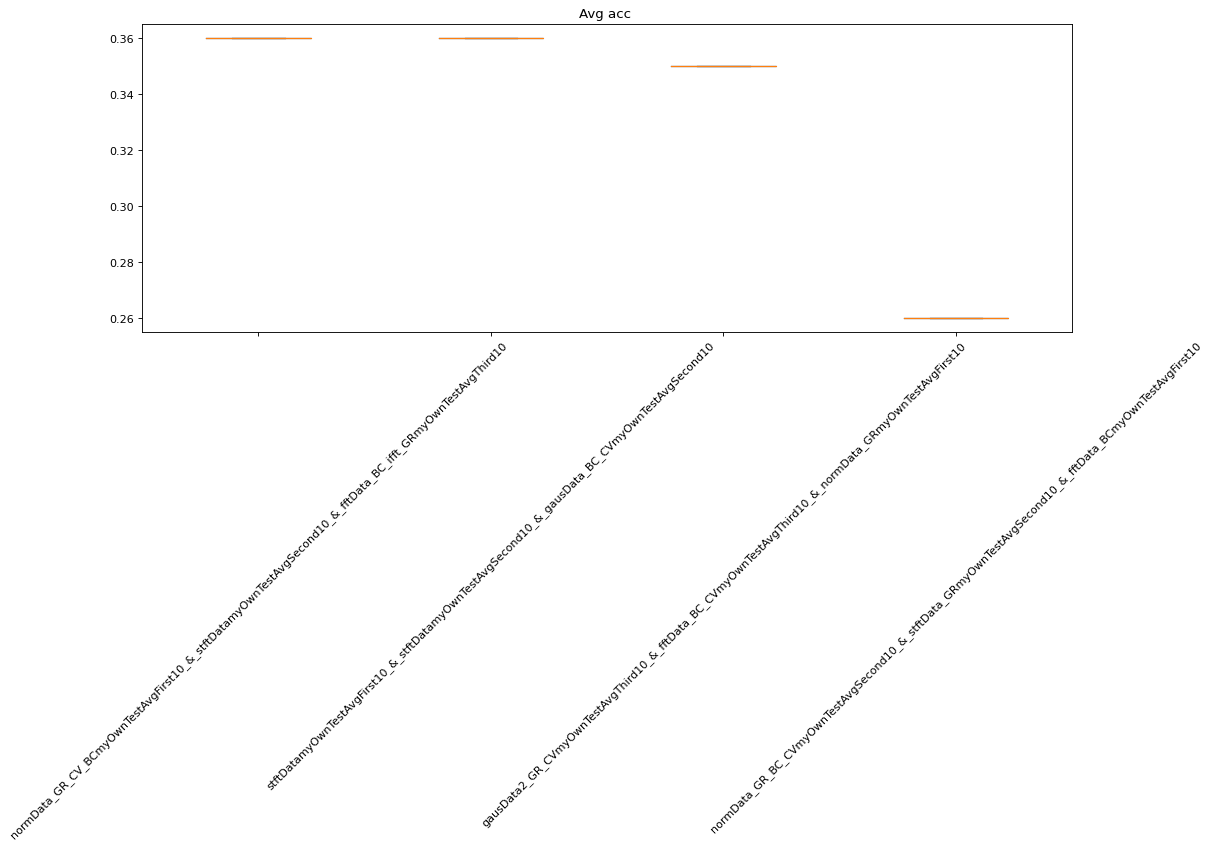

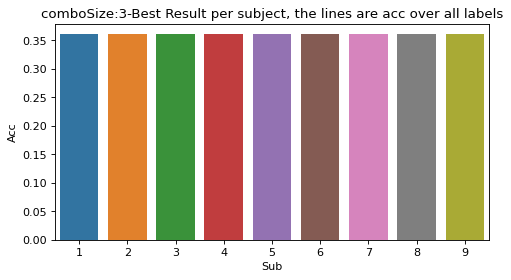

In [406]:
# Average accurracy of all labels, using holdout
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=hcombinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure(figsize=[7,3.5])
worstCombos = plotTop(topPerFeature, featCombos, label, saveTopAvgName=saveTopAvgName)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList.shape)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
# print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
plt.figure(figsize=[7,3.5])
sns.barplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
topDF
if saveHoldTop:
    topDF.to_csv(f"topFeaturesResultsHold/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")
   

['stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10'
 'normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10']
[array(['stftDatamyOwnTestAvgFirst10', 'stftDatamyOwnTestAvgSecond10',
       'gausData_BC_CVmyOwnTestAvgSecond10'], dtype=object), array(['normData_GR_CV_BCmyOwnTestAvgFirst10',
       'stftDatamyOwnTestAvgSecond10',
       'fftData_BC_ifft_GRmyOwnTestAvgThird10'], dtype=object)]


<Figure size 560x280 with 0 Axes>

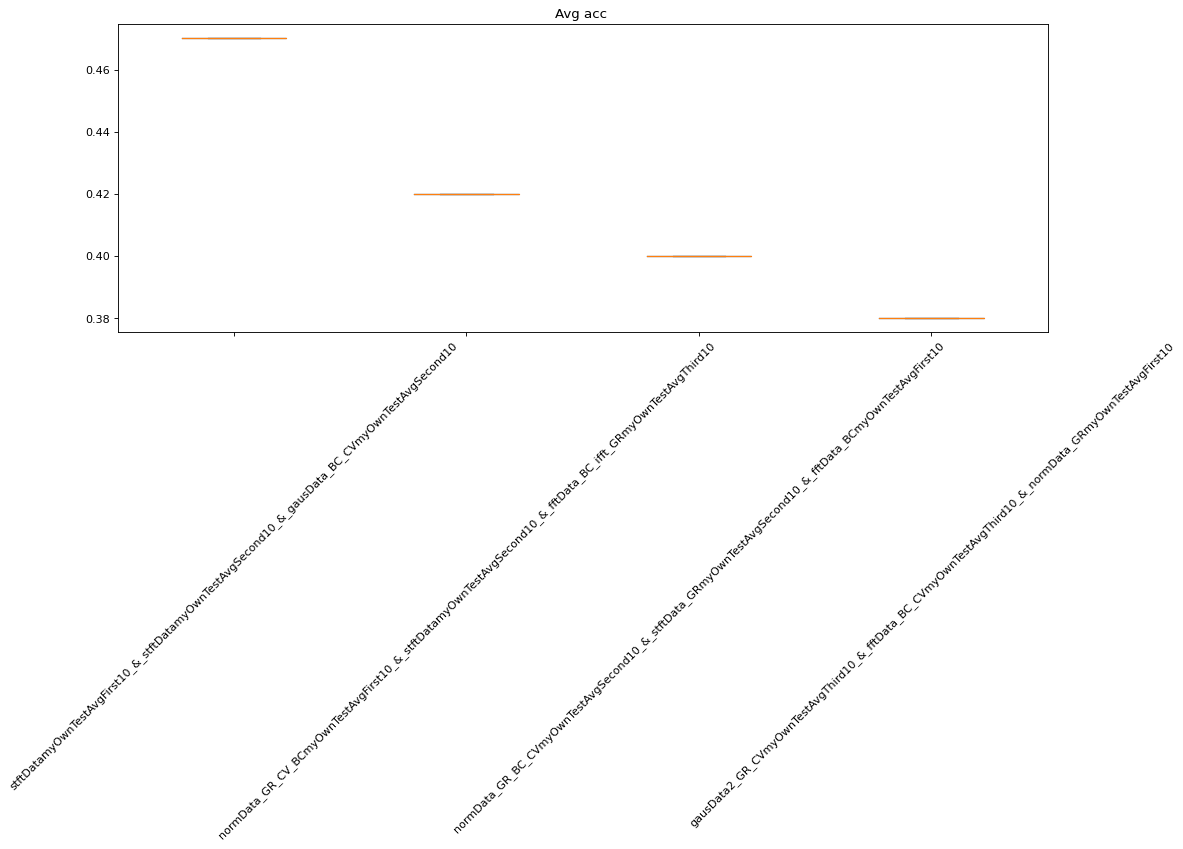

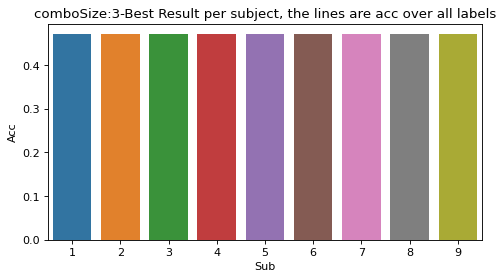

ow


,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.47,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,linear,2.5,4,jjjjsahd


In [407]:
# Average accurracy of all labels, not using holdout
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=combinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure(figsize=[7,3.5])
worstCombos = plotTop(topPerFeature, featCombos, label, saveTopAvgName=saveTopAvgName)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList.shape)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
# print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
plt.figure(figsize=[7,3.5])
sns.barplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
if "my" in featureSelect:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst

In [408]:
if worstCombos is not None:
    print(list(worstCombos.keys()))
    if cmbSize == 1:
        np.save(f"worstFeatures/worstFeats{cmbSize}{paraName}", list(worstCombos.keys()))


In [409]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,normData_GR_BC_CVmyOwnTestAvgSecond10_&_stftData_GRmyOwnTestAvgSecond10_&_fftData_BCmyOwnTestAvgFirst10,gausData2_GR_CVmyOwnTestAvgThird10_&_fftData_BC_CVmyOwnTestAvgThird10_&_normData_GRmyOwnTestAvgFirst10,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10,normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10
0,0.0,0.00,0.00,0.00
1,0.4,0.38,0.47,0.42
2,0.4,0.38,0.47,0.42
3,0.4,0.38,0.47,0.42
4,0.4,0.38,0.47,0.42
5,0.4,0.38,0.47,0.42
6,0.4,0.38,0.47,0.42
7,0.4,0.38,0.47,0.42
8,0.4,0.38,0.47,0.42
9,0.4,0.38,0.47,0.42


In [410]:
print("Top ten highest accuracies")

# topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.47 : subject 1, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5
Accuracy 0.47 : subject 2, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5
Accuracy 0.47 : subject 3, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5
Accuracy 0.47 : subject 4, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5
Accuracy 0.47 : subject 5, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5
Accuracy 0.47 : subject 6, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5
Accuracy 0.47 : subject 7, feature:stftDatamyOwnTestAvgFirst1

In [411]:
# print("Top ten highest accuracies")
# for subTop in topThreeAllSubjects:
#     subTop.reverse()

In [412]:
# Top results, ordered by subject
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[1:]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Accuracy 0.47 : subject 1, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 2, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 3, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 4, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 5, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 6, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 7, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes

In [413]:
topThreeAllSubjects.sort(reverse=True,  key= lambda i: i[0])

In [414]:
# Top results, ordered by best result

# topThreeAllSubjects.sort()

arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:-1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
# print(newArrayOfTopFeatureNames)
# newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
# if saveTopName is not None:
#     np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames)


Accuracy 0.47 : subject 9, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 8, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 7, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 6, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 5, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 4, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10, kernellinear, C:2.5

Accuracy 0.47 : subject 3, feature:stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes

In [415]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.38333333 0.38333333 0.38333333 0.38333333 0.38333333
 0.38333333 0.38333333 0.38333333 0.38333333]


,0,1,2,3,4,5,6,7,8,9,10,11
0,2.79,3.6,3.24,2.7,3.42,3.33,4.23,3.6,3.87,3.78,3.24,3.6


Max average accuracy 4.229999999999999


In [416]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
arrayOfTopFeatureNames2 = []
for maxInd,res in zip(top5[:2], top5Vals[:2]):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    arrayOfTopFeatureNames2.append(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()
    
#     # Top results, ordered by subject

# # for subTop in topThreeAllSubjects[1:]:
# #     print("")
# #     for top in subTop[:-1]:
# #         arrayOfTopFeatureNames.append(top[2])
# #         print(
# #                 f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
# #             )
# arrayOfTopFeatureNames2
# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# arrayOfTopFeatureNames2 = np.array(arrayOfTopFeatureNames2, dtype=object)
# newArrayOfTopFeatureNames2 = []
# for topNames in arrayOfTopFeatureNames2:
#     splitArray = []
#     if "_&_" in topNames:
#         splitArray = np.array(topNames.split("_&_"), dtype=object)
#     else: 
#         splitArray = [topNames]

#     skip = False  
#     if len(splitArray) < cmbSize:
#         continue
#     newArrayOfTopFeatureNames2.append(splitArray)
    
# print(newArrayOfTopFeatureNames2)
# newArrayOfTopFeatureNames2 = np.array(newArrayOfTopFeatureNames2, dtype=object) 
# if saveTopAvgName is not None:
#     np.save(f"topFeatures/{saveTopAvgName}", newArrayOfTopFeatureNames2)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames2)

Based on combAverage
stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10
linear
4.229999999999999

stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10
sigmoid
3.8700000000000006



In [417]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10
linear
0.46999999999999986

stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10
sigmoid
0.43000000000000005

normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10
linear
0.42

normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10
sigmoid
0.39999999999999997

stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10
rbf
0.39999999999999997



In [418]:
def getRes2(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels): 
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1]
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(res[0])
                if onlySignificant == True:
                    if res[1] < minAcc:
                        continue
                res[1] = sres[label+1]
                combRes = sres[combResLabel]
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                if res[1] > topPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topTen) < 10 or topTen[0][0] < res[1]:

                    if len(topTen) == 10:
                        topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        topTen.reverse()
                        topTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort()
                    topCombResTen.sort()

                
                if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                    if len(topThreeThisSubject) == 2:
                        topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topThreeThisSubject.sort( key= lambda i: i[0])
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    topCombResThreeThisSubject.sort( key= lambda i: i[0])
                    
        if len(topThreeThisSubject)>0:
            topThreeAllSubjects.append(topThreeThisSubject)
        if len(topCombResThreeThisSubject)>0:
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    comboAverage = comboAverage / nrOfSubjects
    pd.set_option("display.max_columns", None)

    # For loop through zip of headers and columns,
    # If column has all values == None, Remove column and header.
    subjectResultArray = np.array(subjectResultArray)
    emptyCols = []
    atleastOneEmpty = False
    for hcol, in zip(headers):
        if all(subjectResultArray[:,hcol] == None):
            atleastOneEmpty = True
            emptyCols.append(hcol)
    if atleastOneEmpty: 
        subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
        headers = np.delete(headers, np.array(emptyCols),0)
        comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
        comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
        nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


(36, 7)
Sad
Angry
Happy
Disgusted


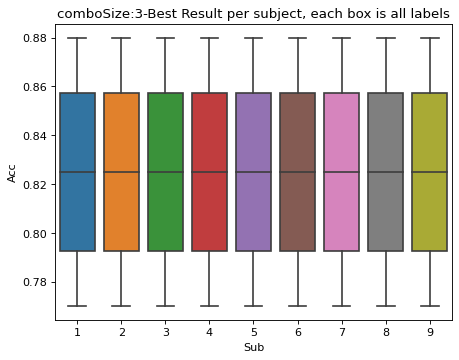

ow


,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.80,1,normData_GR_BC_CVmyOwnTestAvgSecond10_&_stftDa...,rbf,2.5,Sad,jjjjsahd
9,0.85,1,gausData2_GR_CVmyOwnTestAvgThird10_&_fftData_B...,rbf,2.5,Angry,jjjjsahd
18,0.77,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,linear,2.5,Happy,jjjjsahd
27,0.88,1,normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDat...,linear,2.5,Disgusted,jjjjsahd


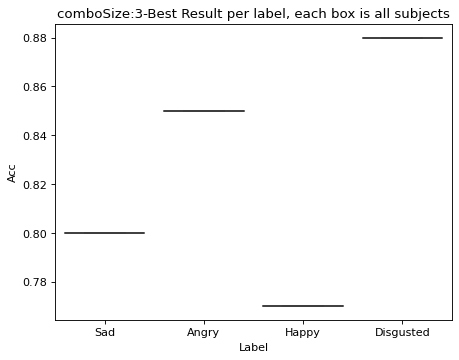

In [419]:
# Not holdout The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. 
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        bestSeparate=True)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
for label in labels:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if saveAvgTop:
    topDF.to_csv(f"topFeaturesResultsAvg/topPerLabel-para-{paraName}-cmb-{cmbSize}")
plt.figure()
sns.boxplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(topDF, y = "Acc", x="Label") # , 
if "my" in featureSelect:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst

   

In [420]:
# arrayOfTopFeatureNames = np.array(pd.unique(topDF["Feat"]))
listOfTopFeatNames = []

for sub in [1,2,3,4,5,6,7,8,9]:
    onlySub = topDF[topDF['Sub'] == f"{sub}"]
    arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
    
    if arrayOfTopFeatureNames.shape[0] < nrOfLabels:
        if nrOfLabels == 4:
            if arrayOfTopFeatureNames.shape[0] < 3:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1]])
            else:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[2], arrayOfTopFeatureNames[0]])
        if nrOfLabels == 2:
            arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[0]])
        # print(arrayOfTopFeatureNames)
        arrayOfTopFeatureNames = np.reshape(arrayOfTopFeatureNames, [-1])
        # print(arrayOfTopFeatureNames)
        # listOfTopFeatNames.extend(arrayOfTopFeatureNames[0])
    listOfTopFeatNames.append(arrayOfTopFeatureNames)
listOfTopFeatNames[2].shape
print(listOfTopFeatNames)
listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# for top in listOfTopFeatNames:
arrayOfTopFeatureNames = listOfTopFeatNames

# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeaturesPerLabel/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)
    print(newArrayOfTopFeatureNames.shape)
    

[array(['normData_GR_BC_CVmyOwnTestAvgSecond10_&_stftData_GRmyOwnTestAvgSecond10_&_fftData_BCmyOwnTestAvgFirst10',
       'gausData2_GR_CVmyOwnTestAvgThird10_&_fftData_BC_CVmyOwnTestAvgThird10_&_normData_GRmyOwnTestAvgFirst10',
       'stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10',
       'normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10'],
      dtype=object), array(['normData_GR_BC_CVmyOwnTestAvgSecond10_&_stftData_GRmyOwnTestAvgSecond10_&_fftData_BCmyOwnTestAvgFirst10',
       'gausData2_GR_CVmyOwnTestAvgThird10_&_fftData_BC_CVmyOwnTestAvgThird10_&_normData_GRmyOwnTestAvgFirst10',
       'stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_gausData_BC_CVmyOwnTestAvgSecond10',
       'normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDatamyOwnTestAvgSecond10_&_fftData_BC_ifft_GRmyOwnTestAvgThird10'],
      dtype=object), array(['normData_GR_BC_CVmyOwnTestAvgSecond10_&_stftD

In [421]:
# listOfTopFeatNames = []
# for sub in [1,2,3,4,5,6,7,8,9]:
#     onlySub = topDF[topDF['Sub'] == f"{sub}"]
#     arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
#     listOfTopFeatNames.append(arrayOfTopFeatureNames)
# listOfTopFeatNames[2].shape
# print(listOfTopFeatNames)
# listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# # for top in listOfTopFeatNames:
# listOfTopFeatNames
# # topDF
# # arrayOfTopFeatureNames = np.array(pd.unique(test["Feat"]))
# arrayOfTopFeatureNames

In [422]:
# table = pd.DataFrame(np.array(comboTotal), columns=headers)
# display(table)

# maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

# for maxInd2 in np.where(comboTotal == maxVal2)[1]:
#     print(headers[maxInd2])
#     print(nrOfSubjects[maxInd2])
#     print(
#         f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
#     )
#     print(allCombinations[maxInd2][0])
#     print(allCombinations[maxInd2][1])
#     print(f"C: {allCombinations[maxInd2][2]} ")


(36, 7)
Sad
Angry
Happy
Disgusted


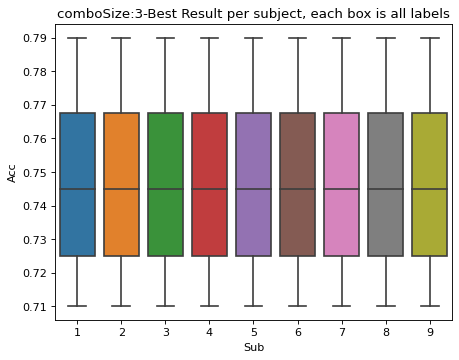

ow


,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.76,1,gausData2_GR_CVmyOwnTestAvgThird10_&_fftData_B...,rbf,2.5,Sad,jjjjsahd
9,0.73,1,gausData2_GR_CVmyOwnTestAvgThird10_&_fftData_B...,rbf,2.5,Angry,jjjjsahd
18,0.71,1,stftDatamyOwnTestAvgFirst10_&_stftDatamyOwnTes...,sigmoid,2.5,Happy,jjjjsahd
27,0.79,1,normData_GR_CV_BCmyOwnTestAvgFirst10_&_stftDat...,linear,2.5,Disgusted,jjjjsahd


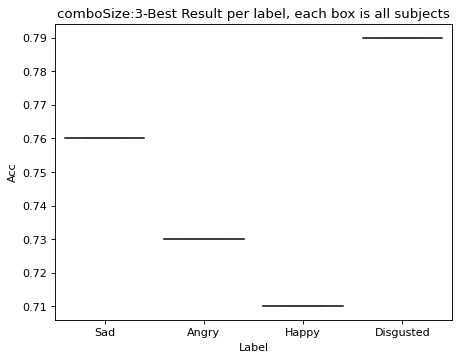

In [423]:
# The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. Using Holdout
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=hcombinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        bestSeparate=True)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
for label in labels:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveHoldTop:
    topDF.to_csv(f"topFeaturesResultsHold/topPerLabel-para-{paraName}-cmb-{cmbSize}")
# if saveTop:
#     topDF.to_csv(f"topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
# if saveAvgTop:
#     topDF.to_csv(f"topFeaturesResultsAvg/topPerLabel-para-{paraName}-cmb-{cmbSize}")
plt.figure()
sns.boxplot(topDF, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(topDF, y = "Acc", x="Label") # , 
#topDF["Sub" == 1]
if "my" in featureSelect:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst


In [424]:
# arrayOfTopFeatureNames = np.array(pd.unique(topDF["Feat"]))
listOfTopFeatNames = []

for sub in [1,2,3,4,5,6,7,8,9]:
    onlySub = topDF[topDF['Sub'] == f"{sub}"]
    arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
    
    if arrayOfTopFeatureNames.shape[0] < nrOfLabels:
        if nrOfLabels == 4:
            if arrayOfTopFeatureNames.shape[0] < 3:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1]])
            else:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[2], arrayOfTopFeatureNames[0]])
        if nrOfLabels == 2:
            arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[0]])
        # print(arrayOfTopFeatureNames)
        arrayOfTopFeatureNames = np.reshape(arrayOfTopFeatureNames, [-1])
        # print(arrayOfTopFeatureNames)
        # listOfTopFeatNames.extend(arrayOfTopFeatureNames[0])
    listOfTopFeatNames.append(arrayOfTopFeatureNames)
listOfTopFeatNames[2].shape
# print(listOfTopFeatNames)
listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# for top in listOfTopFeatNames:
arrayOfTopFeatureNames = listOfTopFeatNames

# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topHoldFeaturesPerLabel/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    # print(newArrayOfTopFeatureNames)
    print(newArrayOfTopFeatureNames.shape)
    

[array(['gausData2_GR_CVmyOwnTestAvgThird10',
       'fftData_BC_CVmyOwnTestAvgThird10',
       'normData_GRmyOwnTestAvgFirst10'], dtype=object), array(['stftDatamyOwnTestAvgFirst10', 'stftDatamyOwnTestAvgSecond10',
       'gausData_BC_CVmyOwnTestAvgSecond10'], dtype=object), array(['normData_GR_CV_BCmyOwnTestAvgFirst10',
       'stftDatamyOwnTestAvgSecond10',
       'fftData_BC_ifft_GRmyOwnTestAvgThird10'], dtype=object), array(['gausData2_GR_CVmyOwnTestAvgThird10',
       'fftData_BC_CVmyOwnTestAvgThird10',
       'normData_GRmyOwnTestAvgFirst10'], dtype=object), array(['gausData2_GR_CVmyOwnTestAvgThird10',
       'fftData_BC_CVmyOwnTestAvgThird10',
       'normData_GRmyOwnTestAvgFirst10'], dtype=object), array(['stftDatamyOwnTestAvgFirst10', 'stftDatamyOwnTestAvgSecond10',
       'gausData_BC_CVmyOwnTestAvgSecond10'], dtype=object), array(['normData_GR_CV_BCmyOwnTestAvgFirst10',
       'stftDatamyOwnTestAvgSecond10',
       'fftData_BC_ifft_GRmyOwnTestAvgThird10'], dtype=object), ar

In [425]:
# for names in featCombos:
#     print(names)

